In [1]:
import os
import pickle
import numpy as np
import detectron2
import torch

import pathlib
import pandas as pd
import pycocotools.mask as RLE
import skimage
import skimage.io

import seaborn as sns
import skimage.measure

import explore_data_spheroidite


import matplotlib.pyplot as plt

from detectron2.structures import instances, Boxes
import torch


ampis_root = pathlib.Path('../src/')
assert ampis_root.is_dir()

import sys
sys.path.append(str(ampis_root))
from ampis import analyze, data_utils
from ampis.structures import instance_set
from ampis.visualize import quick_visualize_iset

In [2]:
dataset_name_ = 'spheroidite'

gt_pickle_path = pathlib.Path('..','data','raw','spheroidite-images','spheroidite-files.pickle')
gt_files_all = explore_data_spheroidite.get_files(gt_pickle_path, 2)
gt_data_all = {key: explore_data_spheroidite.get_ddicts(gt_files_all[key]) for key in gt_files_all}

metadata = explore_data_spheroidite.get_metadata()

In [3]:
#gt_instances = [analyze.instance_set().read_from_ddict(x, True) for x in explore_data_spheroidite.get_ddicts(gt_files_all[key])]
gt_instances = []
for v in gt_data_all.values():
    gt_instances += [instance_set().read_from_ddict(x, True) for x in v] 

In [4]:
pred_data_root = pathlib.Path('..','data','interim','Spheroidite_Results', 'spheroidite_predictions_outputs_compressed.pickle')
with open(pred_data_root, 'rb') as f:
    pred_data_all = pickle.load(f)
pred_instances = []
for v in pred_data_all.values():
    pred_instances += [instance_set().read_from_model_out(v, True)]

In [5]:
pred_instances, gt_instances = analyze.align_instance_sets(pred_instances, gt_instances)

In [6]:
gt = gt_instances[-2]
pred = pred_instances[-2]

In [7]:
img = skimage.io.imread(gt.filepath)
img = skimage.color.gray2rgb(img)

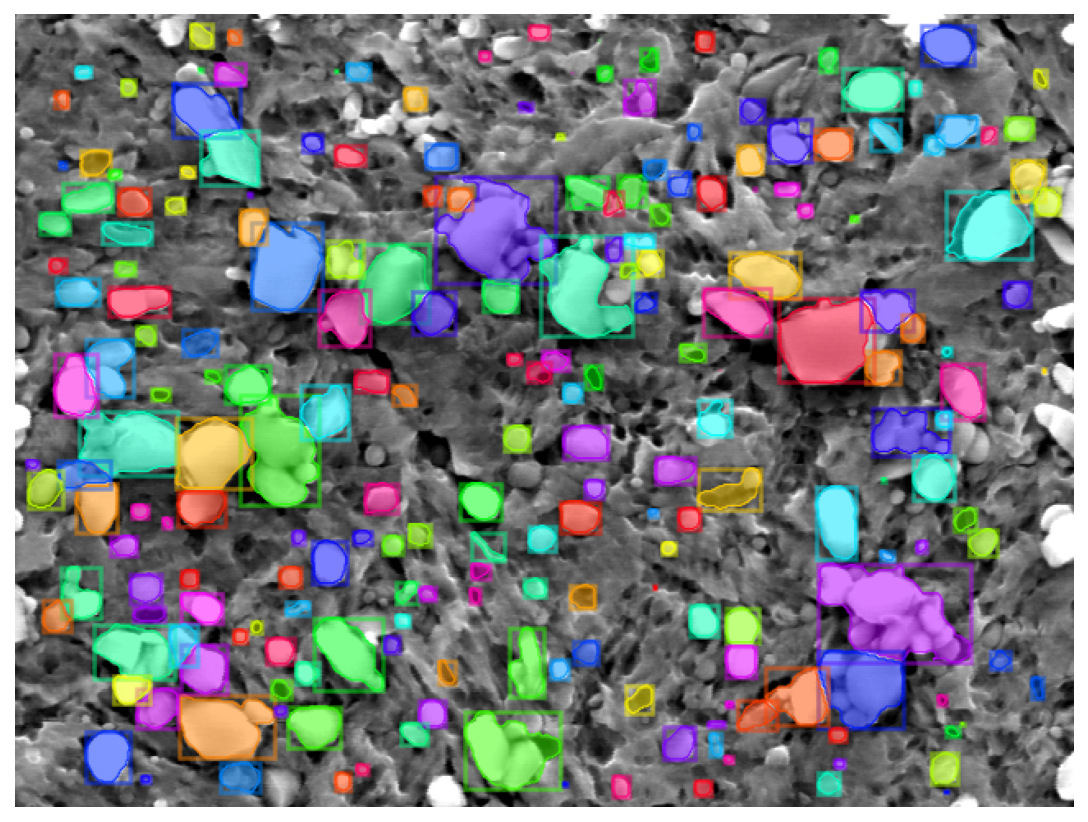

In [8]:
# ground truth
quick_visualize_iset(img, metadata, gt,)

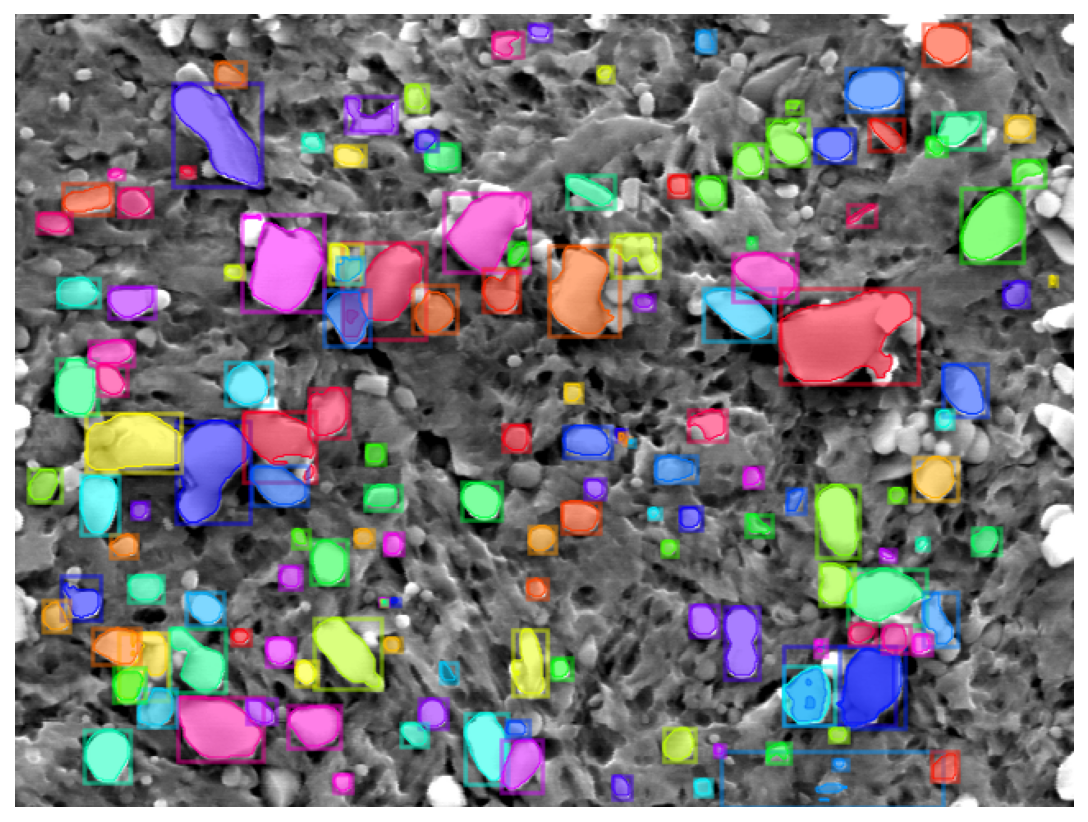

In [9]:
quick_visualize_iset(img, metadata, pred, )

In [10]:
for isetlist in [gt_instances, pred_instances]:
    for iset in isetlist:
        iset.instances = iset.filter_mask_size()
        

In [11]:
mmr = [analyze.mask_match_stats(x.instances.masks, y.instances.masks) for x,y in zip(gt_instances, pred_instances)]

In [12]:
match_precision = [x['match_precision'] for x in mmr]
match_recall = [x['match_recall'] for x in mmr]

mask_precision = [x['mask_precision'] for x in mmr]
mask_recall = [x['mask_recall'] for x in mmr]


In [13]:
def generate_labels(ins):
    labels = []
    counts = {'Training':0,
             'Validation':0,
             'Test':0}
    
    for iset in ins:
        counts[iset.dataset_class] += 1
        labels.append('{} {}'.format(iset.dataset_class, counts[iset.dataset_class]))
    return labels

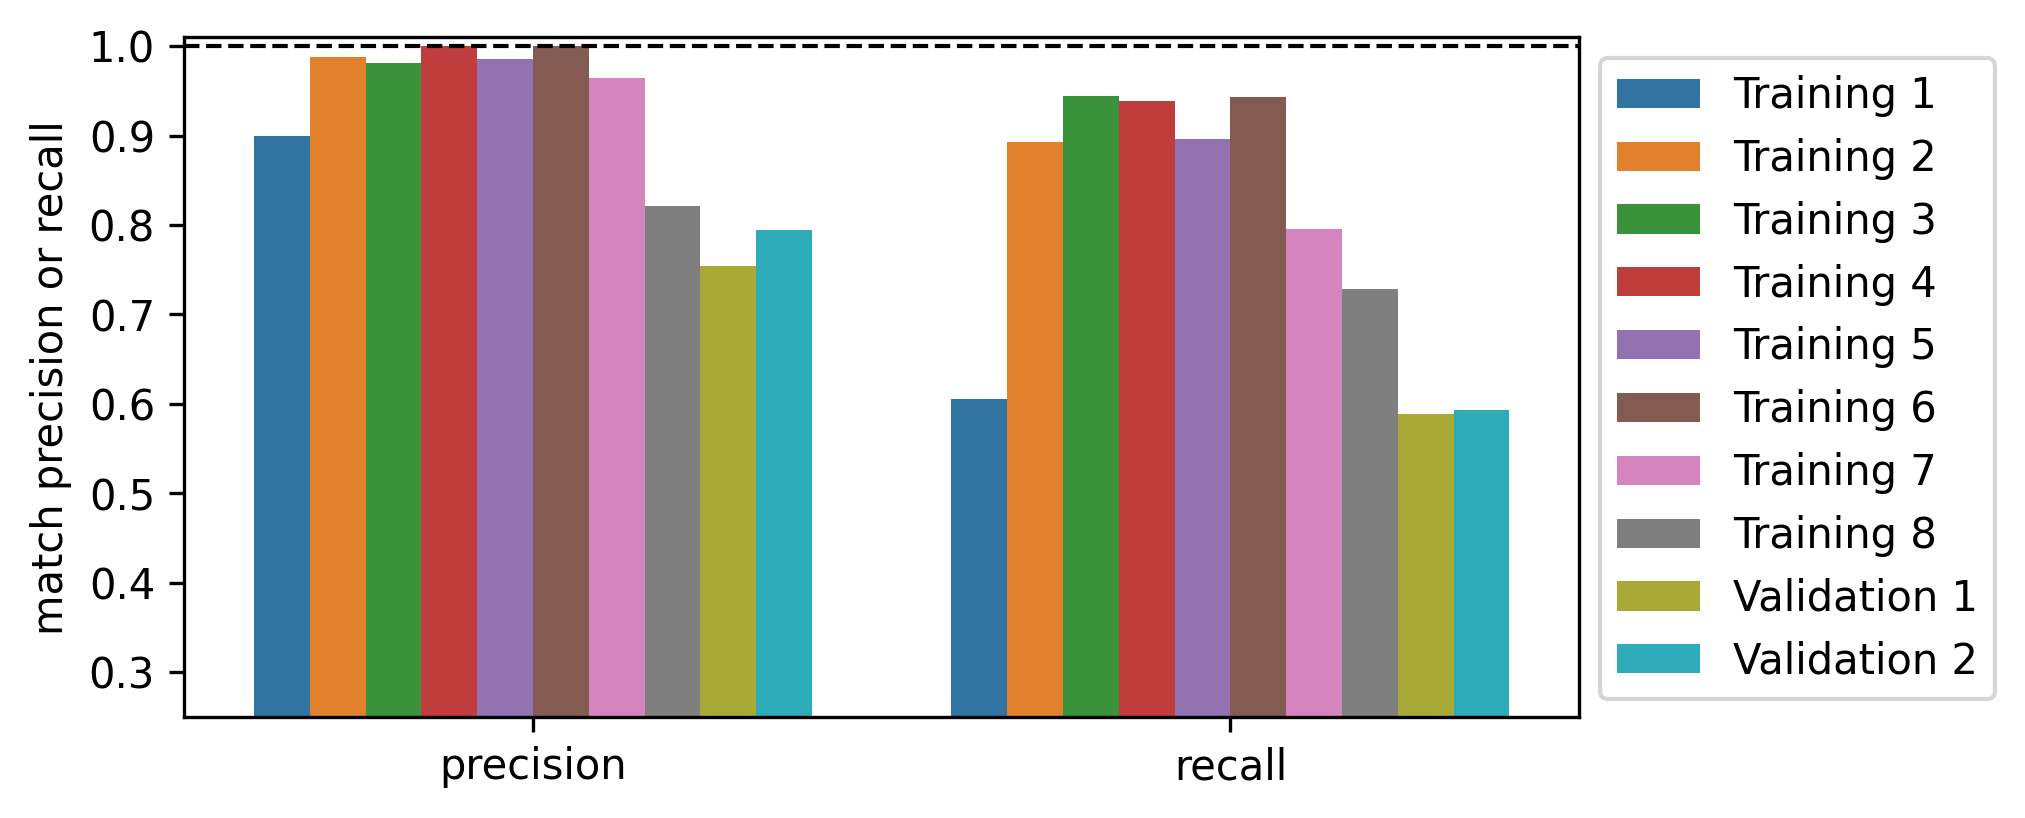

In [14]:
files = generate_labels(gt_instances)

files_list = []
[files_list.extend(files) for _ in range(2)]


y = np.concatenate((match_precision, match_recall), axis=0)

x = []
[x.extend([i]*len(files)) for i in ['precision', 'recall']]

df_match = pd.DataFrame()

df_match['files'] = files_list
df_match['y'] = y
df_match['x'] = x

fig, ax = plt.subplots(figsize=(6,3), dpi=300)
sns.barplot(x="x", y="y",  hue='files', data=df_match, ax=ax)
ax.legend(bbox_to_anchor=(1,1))
ax.set_ylabel('match precision or recall')
ax.set_xlabel('')
xlims = ax.get_xlim()
ax.plot(xlims, [1,1], '--k', linewidth=1)
ax.set_xlim(xlims)
ax.set_ylim([0.25,1.01])
plt.show()


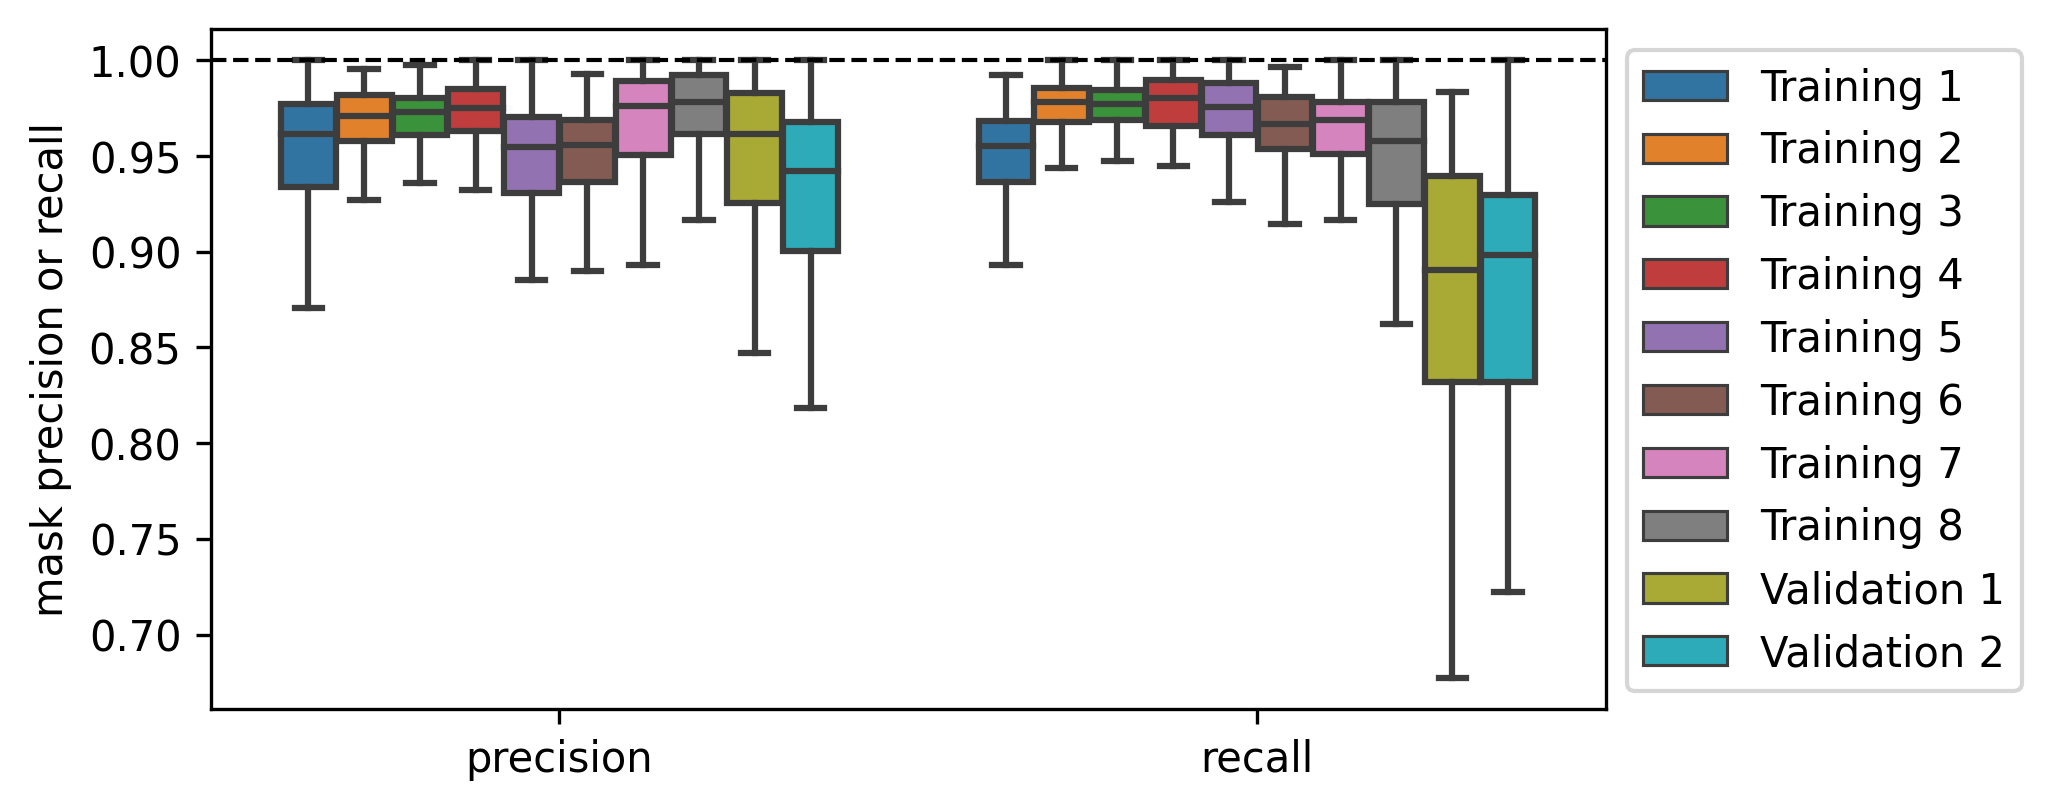

In [15]:
y = np.concatenate((mask_precision, mask_recall,), axis=0)

newx = []
newy = []
newfiles = []

for xi, yi, file in zip(x, y, files_list):
    for yii in yi:
        newx.append(xi)
        newy.append(yii)
        newfiles.append(file)
df_mask = pd.DataFrame()

df_mask['files'] = newfiles
df_mask['y'] = newy
df_mask['x'] = newx

fig, ax = plt.subplots(figsize=(6,3), dpi=300)
#box = ax.get_position()
#ax.set_position([0,0,box.width,box.height])
sns.boxplot(x="x", y="y",  hue='files', data=df_mask, 
            ax=ax, showfliers=False)
l1 = ax.legend(bbox_to_anchor=(1.0,1.0))
ax.set_ylabel('mask precision or recall')
ax.set_xlabel('')
xlims = ax.get_xlim()
ax.plot(xlims, [1,1], '--k', linewidth=1)
ax.set_xlim(xlims)
plt.show()

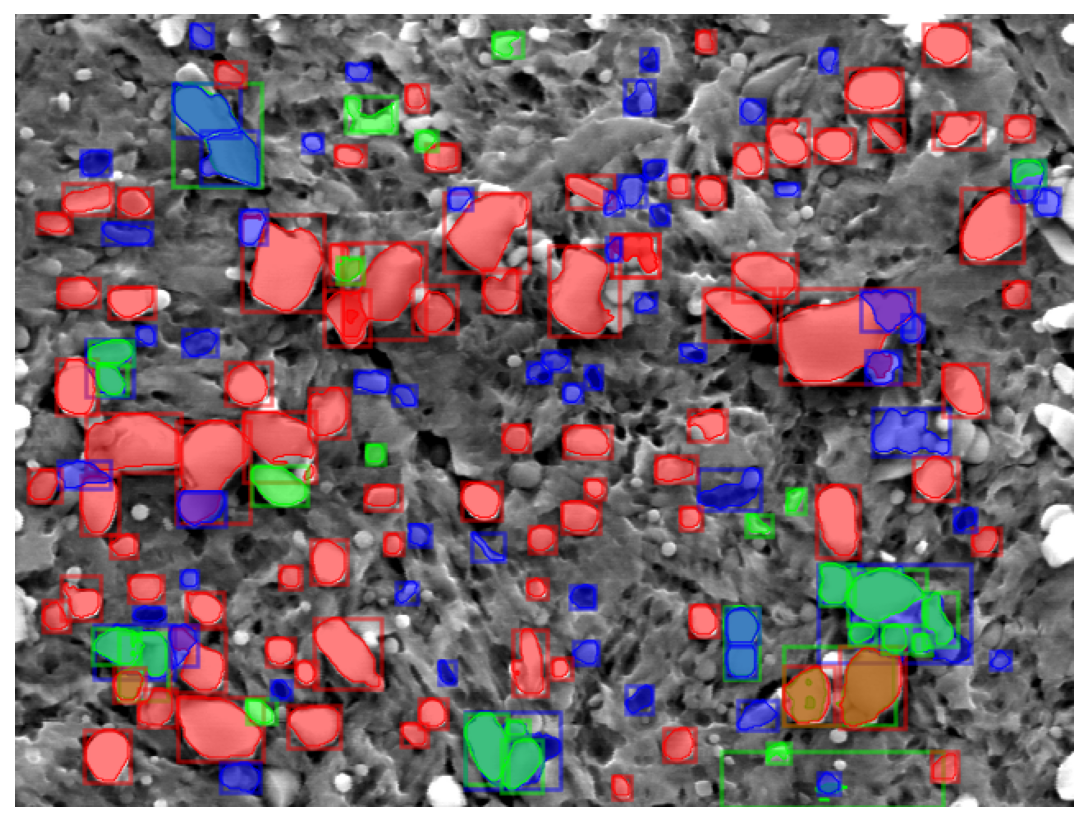

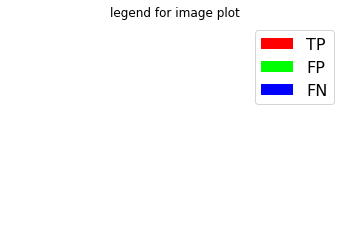

In [16]:
pred = pred_instances[-2]
gt = gt_instances[-2]

gtmasks = analyze.masks_to_rle(gt.instances.masks)
predmasks = analyze.masks_to_rle(pred.instances.masks)
match_results_ = analyze.rle_instance_matcher(gtmasks, predmasks)


is_match, colormap = analyze.match_visualizer(gt, pred, match_results_)

img = skimage.io.imread(gt.filepath)
img = skimage.color.gray2rgb(img)
quick_visualize_iset(img, metadata, is_match)

fig, ax = plt.subplots(1,1)
for i, name in enumerate(['TP','FP','FN']):
    ax.bar(-1000-i, 4+i, color=colormap[name], label=name)
    
ax.axis([0,10,0,10])
ax.legend(fontsize=16)
ax.set_title('legend for image plot')
ax.axis('off')
    
plt.show()


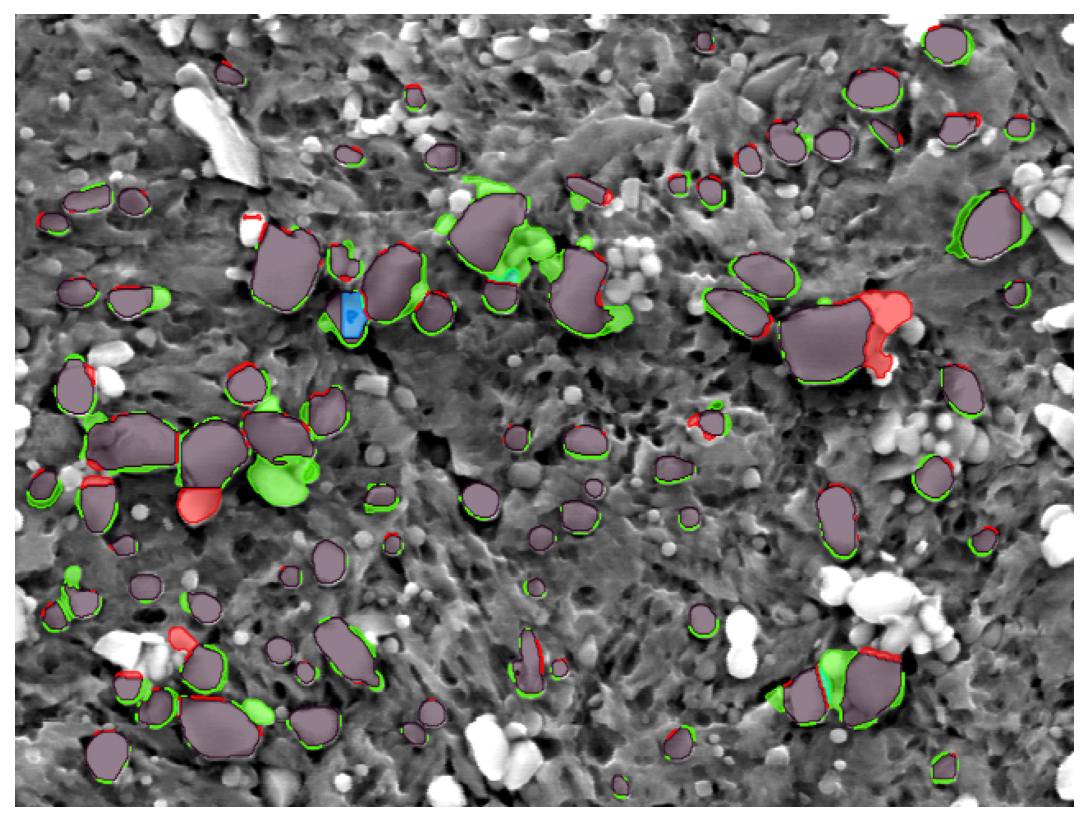

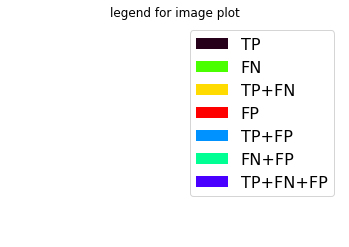

In [17]:
mask_iset, color_labels = analyze.mask_visualizer(gt.instances.masks, pred.instances.masks)

img = skimage.io.imread(gt.filepath)
img = skimage.color.gray2rgb(img)
colors = sns.color_palette(n_colors=7)
colors[1] = [1,0,0]
colors[2] = [0,1,0]
colors[3] = [0.8, 0.8, 0.8]

quick_visualize_iset(img, metadata, mask_iset)


fig, ax = plt.subplots(1,1)
for i in range(7):
    ax.bar(-1000-i, 4+i, color=mask_iset.instances.colors[i], label=color_labels[i+1])
    ax.axis('off')
    
ax.axis([0,10,0,10])
ax.legend(fontsize=16)
ax.set_title('legend for image plot')

    
plt.show()


In [18]:
for set_list in [gt_instances, pred_instances]:
    for iset in set_list:
        iset.compute_rprops()

In [19]:
save_data=True
if save_data:
    for iset, name in zip([gt_instances, pred_instances], ['gt', 'pred']):
        with open('../data/interim/instance_sets/{}_{}_instance_sets.pickle'.format(dataset_name_, name), 'wb') as f:
            pickle.dump(iset, f)